In [2]:
# import libraries
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.datasets import imdb

In [3]:
# load dataset
vocab_size = 20000 # work only with 20000 words

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

#### Define hyperparameters

In [14]:
max_len = 200 # maximum length of sentence
embed_dim = 32 # length of embedding vector for each token
num_head = 2 # number of heads for multi-head attention
ff_dim = 32 # feedforward dimension

#### Data preprocessing

In [8]:
from keras.preprocessing.sequence import pad_sequences

In [27]:
x_train; # data already in numerical format so no tokenizer needed

In [12]:
# padding
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [13]:
x_train.shape, x_test.shape

((25000, 200), (25000, 200))

#### Build model

In [15]:
# Input Layer
inputs = Input(shape=(max_len,))

###### -------- Embedding Block---------------############

# Token Embedding Layer
token_emb_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)
x = token_emb_layer(inputs)   # connecting input layer to token embedding layer

# Positional Embedding Layer
positions = tf.range(0, max_len) # tensor of position from 0 to 199
pos_emb_layer = Embedding(input_dim=max_len, output_dim=embed_dim)
positions_emb = pos_emb_layer(positions) # connecting positions embedding input to position embedding layer

# Add the token + position Embedding
x = x + positions_emb 

###### -------- Embedding Block---------------############



###### -------- Transformer Block---------------############
# 1. Multi-head self attention
# 2 heads are there and each receives double embedding as input
attention_output = MultiHeadAttention(num_heads=num_head, key_dim=embed_dim) (x, x)  

attention_output = Dropout(0.1) (attention_output) # dropout to avoid overfitting

# Residual Connections (add + norm)
x1 = LayerNormalization() (x + attention_output) # layer normalization

# Feedforward Neural Network
ffn = Dense(ff_dim, activation='linear')(x1)
ffn = Dense(embed_dim)(ffn) 
ffn = Dropout(0.1)(ffn)

# Residual Connections (add + norm)
x2 = LayerNormalization() (x1 + ffn) # layer normalization
###### -------- Transformer Block---------------############



###### -------- Classification Head---------------############
x3 = GlobalAveragePooling1D()(x2)   # smoothen and convert to 1D
x3 = Dropout(0.1)(x3)
x3 = Dense(20, activation='relu')(x3)
x3 = Dropout(0.1)(x3)
###### -------- Classification Head---------------############



#####--------- Output Layer-------------- ######
outputs = Dense(1, activation='sigmoid')(x3)

In [16]:
# Creating model
model = Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 32)   │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 32)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 32)   │      8,416 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 32)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 32)   │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 32)   │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 32)   │      1,056 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 32)   │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 32)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 32)   │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        660 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 651,337 (2.48 MB)

 Trainable params: 651,337 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

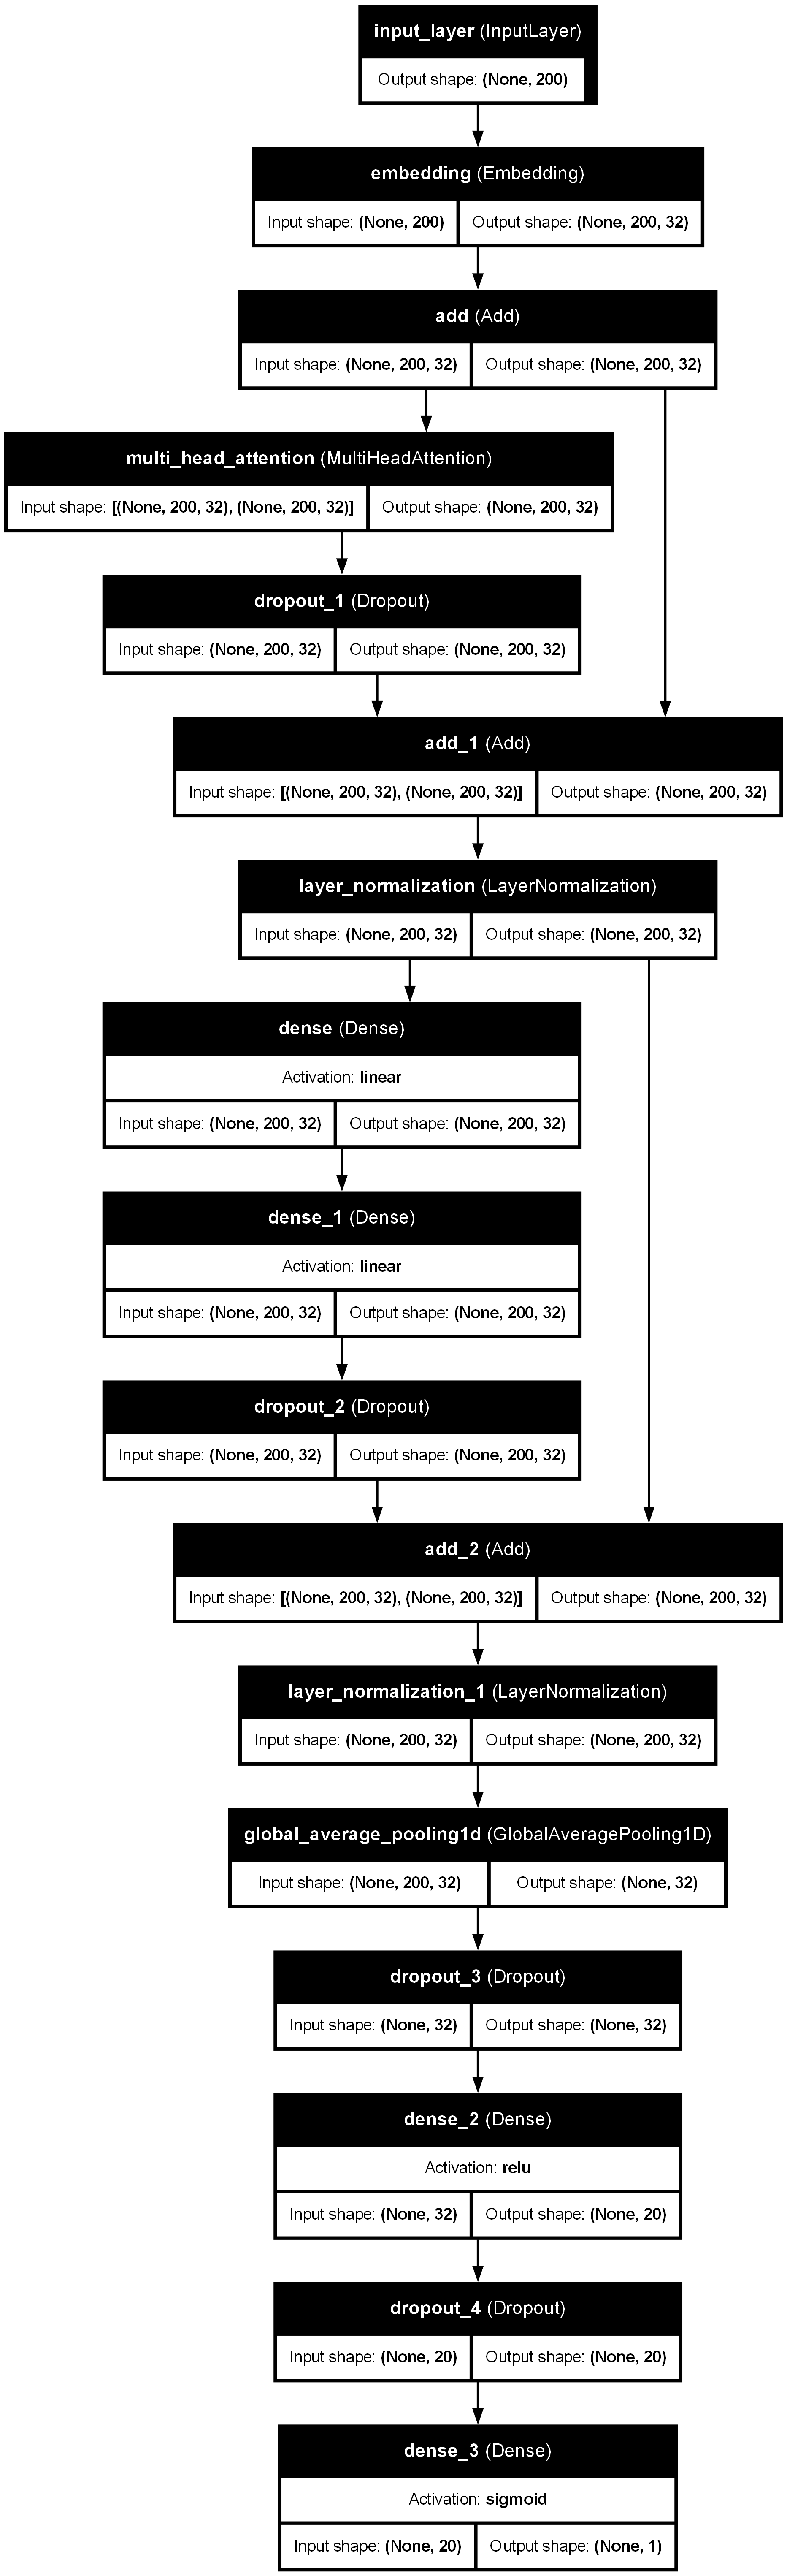

In [23]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

# plt.figure(figsize=(6,4))
plot_model(model, show_layer_names=True, show_layer_activations=True, show_shapes=True)

In [ ]:
# Compile model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# Train model

hist = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.8155 - loss: 0.3897 - val_accuracy: 0.8675 - val_loss: 0.3130
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9259 - loss: 0.1984 - val_accuracy: 0.8686 - val_loss: 0.3311
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.9573 - loss: 0.1226 - val_accuracy: 0.8538 - val_loss: 0.3936
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.9768 - loss: 0.0751 - val_accuracy: 0.8486 - val_loss: 0.5419
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.9860 - loss: 0.0503 - val_accuracy: 0.8419 - val_loss: 0.5529


In [50]:
# prediction
new = x_test[100]
new

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     1,     6,  1605,  7334,    33,     4,   863,
           7,    14,    22,    62,   306,     8,  7147,    43,   160,
         995, 12125, 12112,     2,  8462,  3340,     4,   552,   121,
         383,  9538,   341,     5,     4,   156,    26,    32,   616,
        2118,    25,   165,   181,     8,   783,   190,  1545,  5779,
          53,    10,    10,   247,    74,  1152,    23,  3883,  2120,
           5,   599,   151,    50,     9,     6,   117,     7,   257,
          57,   383,

In [51]:
import numpy as np

In [52]:
new = np.reshape(new, (1, max_len))

In [53]:
new.shape

(1, 200)

In [56]:
model.predict(new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


array([[0.05795337]], dtype=float32)